## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting  import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt


In [2]:
 df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# Make Month_Invoiced a datetime object
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)

In [6]:
# Set that as the index
df = df.set_index('Month_Invoiced').sort_index()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Customer_Id        790458 non-null  int64  
 1   Invoice_Id         790458 non-null  int64  
 2   Subscription_Type  790458 non-null  float64
 3   Amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


In [8]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [9]:
# Drop them ids
df.drop(columns=['Customer_Id', 'Invoice_Id','Subscription_Type'], inplace = True)

In [10]:
df.head()

,Amount
Month_Invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0


In [11]:
df = df.groupby(['Month_Invoiced'])[['Amount']].sum()

In [12]:
df.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [13]:
# compute num of rows in entire df for refrence later
len(df)

48

In [14]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)
train_size

24

In [15]:
# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size =  int(len(df) * .3)
validate_size

14

In [16]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df)-train_size-validate_size)
test_size

10

In [17]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

38

In [18]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [19]:
# sum of train, validate and test = total number of rows? 
len(train) + len(test) + len(validate) ==len(df)

True

In [20]:
# test the row starts
df.head(1) == train.head(1)

,Amount
Month_Invoiced,
2014-01-31,True


In [21]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])

,Amount
Month_Invoiced,
2015-12-31,51505.0
2016-01-31,51955.0


In [22]:
pd.concat([validate.tail(1), test.head(1)])

,Amount
Month_Invoiced,
2017-02-28,53440.0
2017-03-31,53480.0


In [23]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

,Amount
Month_Invoiced,
2017-12-31,53805.0
2017-12-31,53805.0


In [24]:
def plot_samples(target_var):
    '''
   this function will plot everything
   '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])

    plt.title(col)

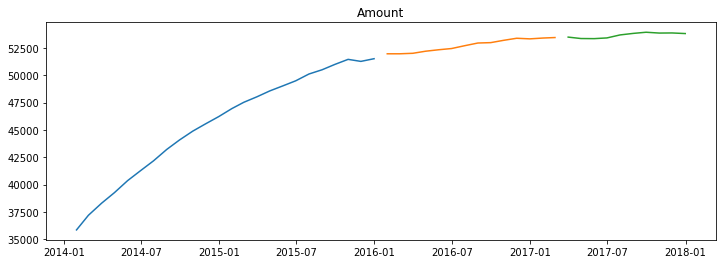

In [25]:
# plot the data points, color by train, validate, test
for col in train.columns:
    plot_samples(col)
    plt.show

In [26]:
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values and the predicted values
    and compute the mean_squared_error and then take the sqrt returning a rounded rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),0)
    return rmse

In [27]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))
    plt.show()



In [28]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [29]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [30]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function will take in the model type as a string, target variable
    as a string, and run the evaluate function to compute rmse, 
    and append to the dataframe a row with the model type, 
    target variable and rmse. 
    '''
    rmse = evaluate(target_var)
    d= {'model_type':[model_type], 'target_var':[target_var], 'rmse':[rmse]}
    d= pd.DataFrame(d)
    return eval_df.append(d, ignore_index= True)

## Forecast 

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

In [31]:
# create var 'items' with last observed value
Amount = train['Amount'][-1]
Amount

51505.0

In [32]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'Amount':[Amount]}, index = validate.index)

In [33]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


Amount --RMSE: 1343


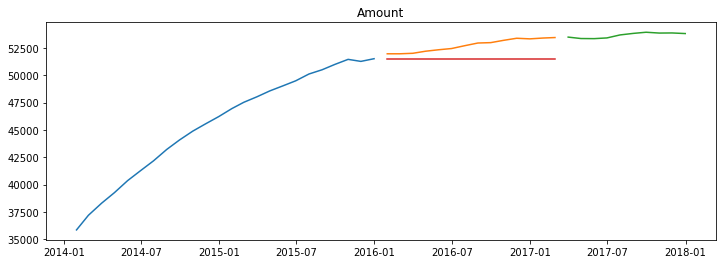

In [34]:
for col in train.columns:
    plot_and_eval(col)

In [35]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [36]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

In [37]:
Amount= round(train['Amount'].mean(), 0)

def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [Amount]}, index = validate.index)
    return yhat_df

In [38]:
yhat_df = make_predictions()

Amount --RMSE: 7180


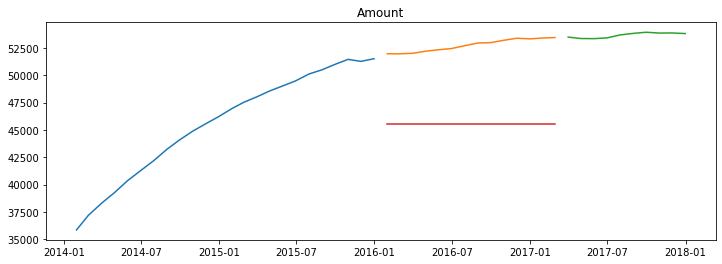

In [39]:
for col in train.columns:
    plot_and_eval(col)

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)

In [41]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7180.0


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

Amount --RMSE: 1343


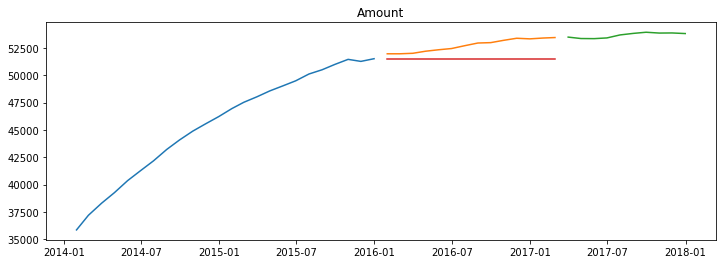

Amount --RMSE: 1455


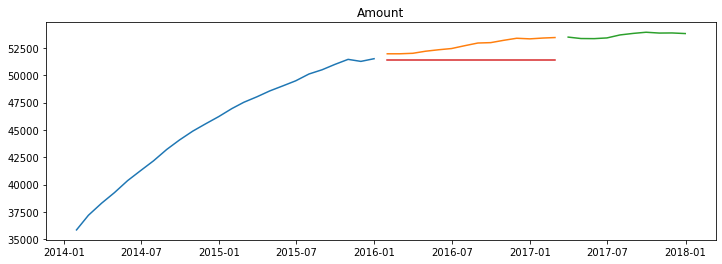

Amount --RMSE: 1436


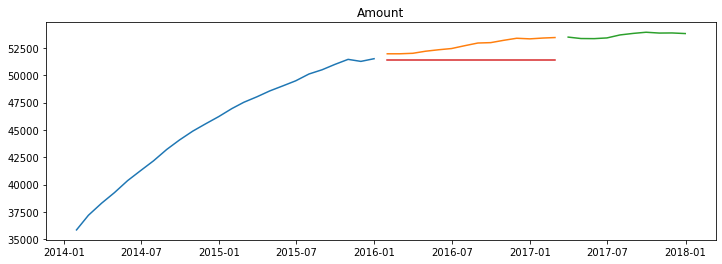

Amount --RMSE: 1533


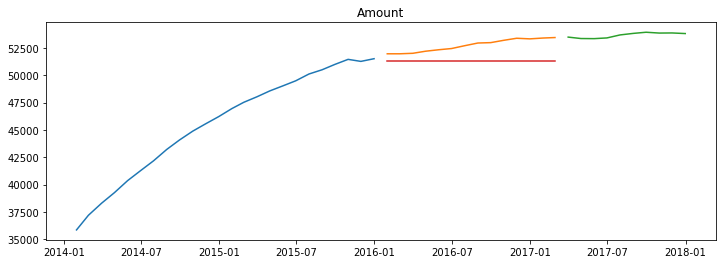

Amount --RMSE: 1684


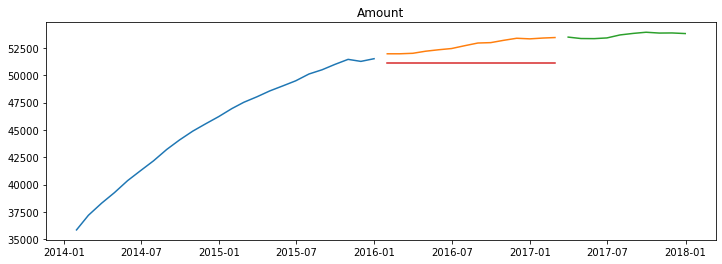

Amount --RMSE: 1847


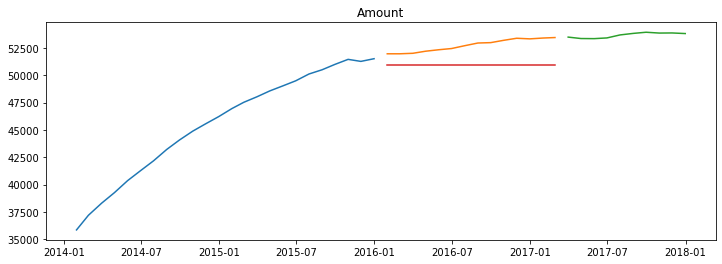

Amount --RMSE: 2050


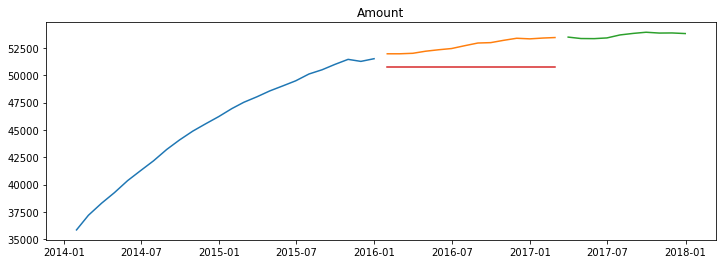

Amount --RMSE: 2259


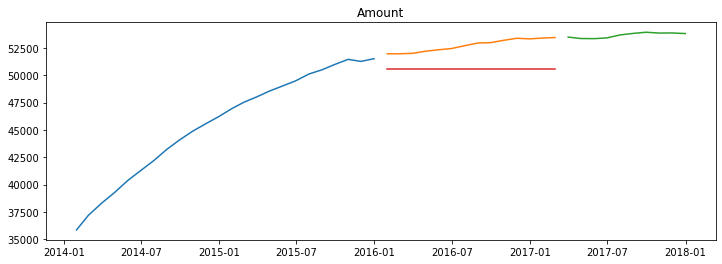

Amount --RMSE: 2472


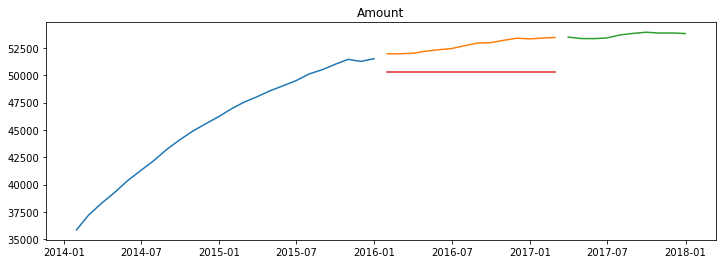

Amount --RMSE: 2696


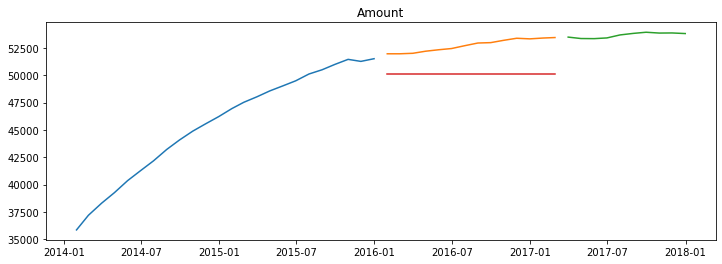

Amount --RMSE: 2925


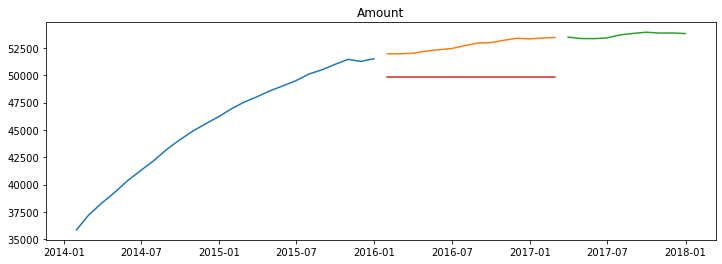

Amount --RMSE: 3164


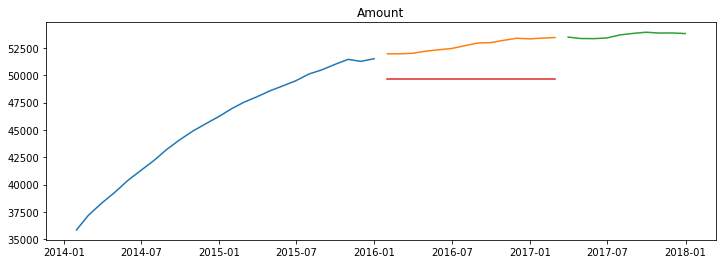

In [42]:
period = range(1,13)

for i in period:
    Amount = train['Amount'].rolling(i).mean().iloc[-1]
    yhat_df = make_predictions()
    for col in train.columns:
        plot_and_eval(col)
    for col in train.columns:
        eval_df = append_eval_df(model_type = f'moving_average_{i}_months', target_var = col)
    plt.show()

In [43]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7180.0
2,moving_average_1_months,Amount,1343.0
3,moving_average_2_months,Amount,1455.0
4,moving_average_3_months,Amount,1436.0
5,moving_average_4_months,Amount,1533.0
6,moving_average_5_months,Amount,1684.0
7,moving_average_6_months,Amount,1847.0
8,moving_average_7_months,Amount,2050.0
9,moving_average_8_months,Amount,2259.0


#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

Amount 



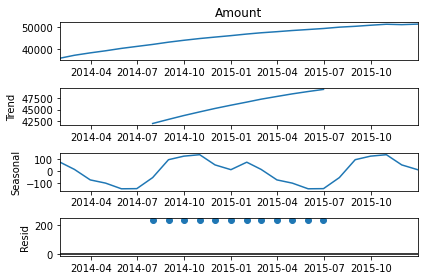

In [44]:
import statsmodels.api as sm 

for col in train.columns:
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [49]:
for col in train.columns:
    model = Holt(validate[col], exponential = False)
    model = model.fit(smoothing_level = .55,
                      smoothing_slope = .62,
                      optimized = False)

    yhat = model.predict(start =test.index[0], end = test.index[-1])

    yhat_df[col]= round(yhat, 2)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [50]:
test.index[-1]

Timestamp('2017-12-31 00:00:00')

In [51]:
yhat_df

,Amount
Month_Invoiced,
2016-01-31,NaN
2016-02-29,NaN
2016-03-31,NaN
2016-04-30,NaN
2016-05-31,NaN
2016-06-30,NaN
2016-07-31,NaN
2016-08-31,NaN
2016-09-30,NaN


In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)
    plot_and_eval(col)

In [ ]:
eval_df

In [ ]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1,
                      smoothing_slope = .1,
                      optimized = False)

    yhat = model.predict(start = validate.index[0], end = validate.index[-1])

    yhat_df[col]= round(yhat, 2)

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)
    plot_and_eval(col)